In [1]:
import smash
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import pickle
import matplotlib.colors as mcolors
import os
import pyflwdir
import rasterio
from rasterio.enums import Resampling
from smash.factory.mesh._tools import _get_transform
# from rasterio.crs import CRS

meson-python: building hydro-smash: /home/aelbaz/anaconda3/envs/smash-dev-pouet/bin/ninja
[1/5] Generating write_version_file with a custom command
[2/5] Compiling Fortran object smash/fcore/_libfcore.cpython-312-x86_64-linux-gnu.so.p/operator_md_routing_operator.f90.o
../../smash/fcore/operator/md_routing_operator.f90:1437:41:

 1399 |                 do col = 1, mesh%ncol
      |                                     2    
......
 1437 |                             if (hsw(row, col - 1) * mesh%dx(row, col - 1) * mesh%dy(row, col - 1)&
      |                                         1
../../smash/fcore/operator/md_routing_operator.f90:1440:41:

 1399 |                 do col = 1, mesh%ncol
      |                                     2    
......
 1440 |                                 hsw(row, col - 1) = hsw(row, col - 1) + hsw(row, col) * &
      |                                         1
../../smash/fcore/operator/md_routing_operator.f90:1440:61:

 1399 |                 do col = 1, 

In [2]:

setup = {
    "start_time": "2014-09-15 00:00",
    "end_time": "2015-09-15 01:00", #"2014-09-15 01:00", # ne pleut pas...
    "dt": 3_600,
    "hydrological_module": "gr4",
    "routing_module": "sw2d",
    "read_qobs": True,
    "qobs_directory": "./Cance-dataset/qobs",
    "read_prcp": True,
    "prcp_conversion_factor": 0.1,
    "prcp_directory": "./Cance-dataset/prcp",
    "read_pet": True,
    "daily_interannual_pet": True,
    "pet_directory": "./Cance-dataset/pet",
    "read_descriptor": False,
    "read_bathymetry": True,
    "bathymetry_format":"tif",
    "bathymetry_file":"./fake_topography.tif"
}

In [3]:

gauge_attributes = pd.read_csv("./Cance-dataset/gauge_attributes.csv")
mesh = smash.factory.generate_mesh(
    flwdir_path="./Cance-dataset/France_flwdir.tif",    
    x=list(gauge_attributes["x"]),
    y=list(gauge_attributes["y"]),
    area=list(gauge_attributes["area"] * 1e6), # Convert km² to m²
    code=list(gauge_attributes["code"]),
)


</> Reading precipitation: 100%|██████████| 8761/8761 [00:03<00:00, 2491.57it/s]
/home/aelbaz/Bureau/smash-fork-sw2d/smash/core/model/_build_model.py:93: UserWarning: Warning(s) linked to precipitation reading.
Missing warning: missing 5811 file(s): ['2014-12-19 00:00', '2015-01-16 00:00', '2015-01-16 01:00', '2015-01-16 02:00', '2015-01-16 03:00', '2015-01-16 04:00', '2015-01-16 05:00', '2015-01-16 06:00', '2015-01-16 07:00', '2015-01-16 08:00', '2015-01-16 09:00', '2015-01-16 10:00', '2015-01-16 11:00', '2015-01-16 12:00', '2015-01-16 13:00', '2015-01-16 14:00', '2015-01-16 15:00', '2015-01-16 16:00', '2015-01-16 17:00', '2015-01-16 18:00', '2015-01-16 19:00', '2015-01-16 20:00', '2015-01-16 21:00', '2015-01-16 22:00', '2015-01-16 23:00', '2015-01-17 00:00', '2015-01-17 01:00', '2015-01-17 02:00', '2015-01-17 03:00', '2015-01-17 04:00', '2015-01-17 05:00', '2015-01-17 06:00', '2015-01-17 07:00', '2015-01-17 08:00', '2015-01-17 09:00', '2015-01-17 10:00', '2015-01-17 11:00', '2015-01-

</> Computing mean atmospheric data
</> Adjusting GR interception capacity
[[-99.         -99.         -99.         -99.         -99.
  -99.         -99.         -99.         -99.         -99.
  -99.         -99.           3.1970558    3.2384772  -99.
  -99.         -99.         -99.         -99.         -99.
  -99.         -99.         -99.         -99.         -99.
  -99.         -99.         -99.        ]
 [-99.         -99.         -99.         -99.         -99.
  -99.         -99.         -99.         -99.         -99.
    3.5798984    3.138477     3.097056   -99.         -99.
  -99.         -99.         -99.         -99.         -99.
  -99.         -99.         -99.         -99.         -99.
  -99.         -99.         -99.        ]
 [-99.         -99.         -99.         -99.         -99.
  -99.         -99.           3.5213199    3.4798985    3.5213199
    3.4798985    3.5213199    2.9970558    3.0384772  -99.
  -99.         -99.         -99.         -99.         -99.
  -99.  

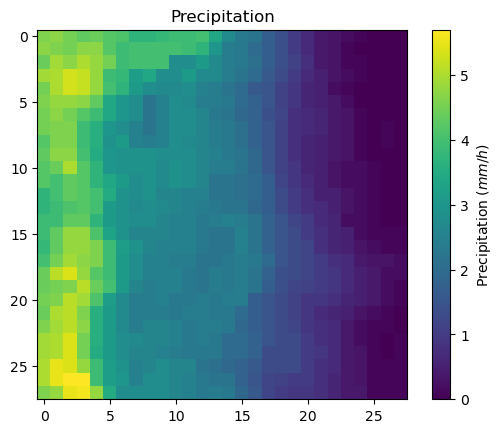

In [4]:

model = smash.Model(setup, mesh)

print(model.physio_data.bathymetry)
print("youyou")
print(model.atmos_data.prcp)

plt.imshow(model.atmos_data.prcp[..., 1200]);

plt.colorbar(label="Precipitation ($mm/h$)");

plt.title("Precipitation");

res = model.forward_run(
    return_options={
    "internal_fluxes":True,
    "q_domain":True,
    },
)

In [5]:

if model.setup.routing_module == "sw2d":

    hsw = res.sw2d["hsw"]
    eta = res.sw2d["eta"]
    qx = res.sw2d["qx"]
    qy = res.sw2d["qy"]
    times = res.sw2d_times

    with h5py.File("hsw.hdf5", "w") as f:
        f.create_dataset("hsw", data=hsw)
    with h5py.File("eta.hdf5", "w") as f:
        f.create_dataset("eta", data=eta)
    with h5py.File("qx.hdf5", "w") as f:
        f.create_dataset("qx", data=qx)
    with h5py.File("qy.hdf5", "w") as f:
        f.create_dataset("qy", data=qy)

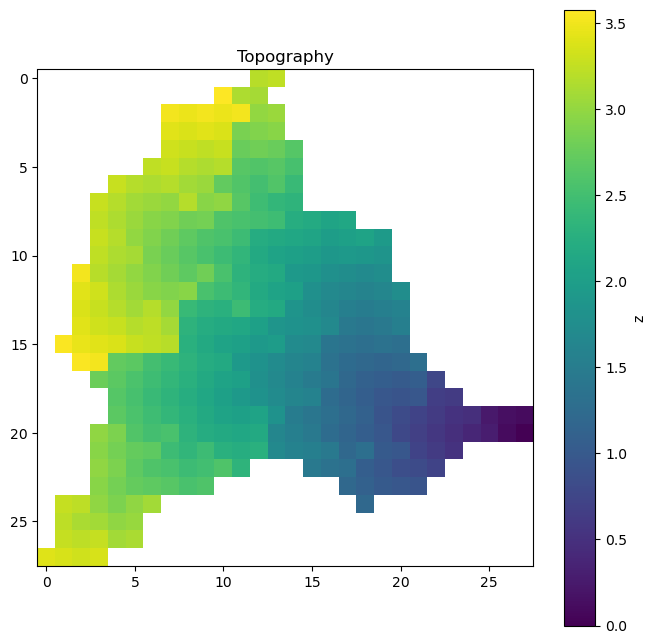

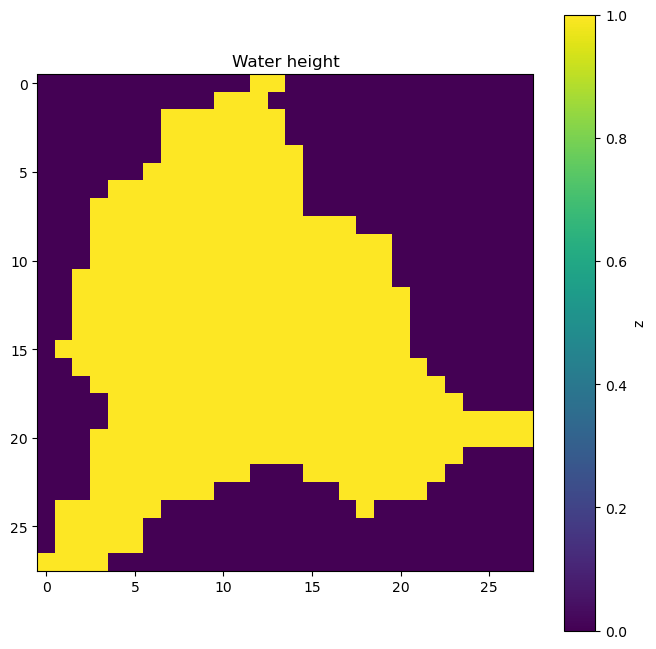

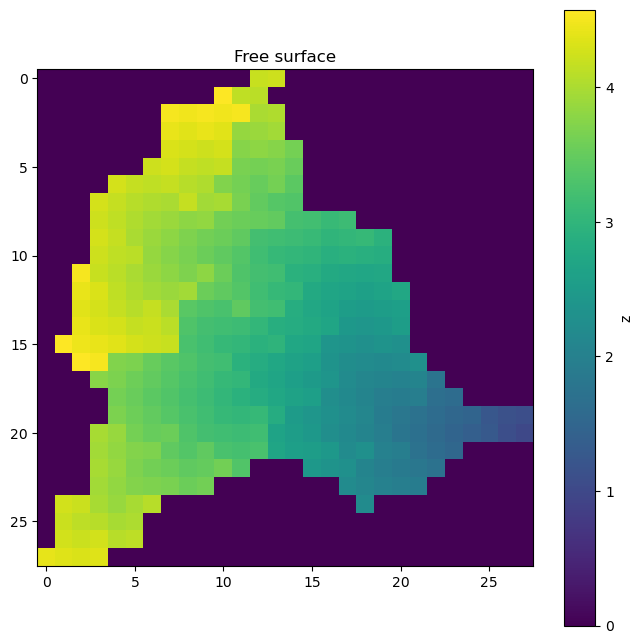

In [6]:
bathymetry = np.where(
    model.physio_data.bathymetry == -99,
    np.nan,
    model.physio_data.bathymetry
)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(bathymetry)
plt.colorbar(label="z")
plt.title("Topography")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(hsw[:,:,0])
plt.colorbar(label="z")
plt.title("Water height")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(eta[:,:,0])
plt.colorbar(label="z")
plt.title("Free surface")
plt.show()


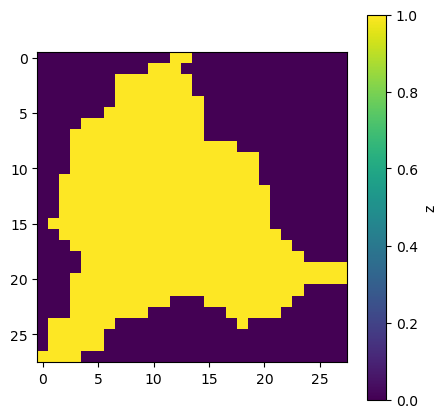

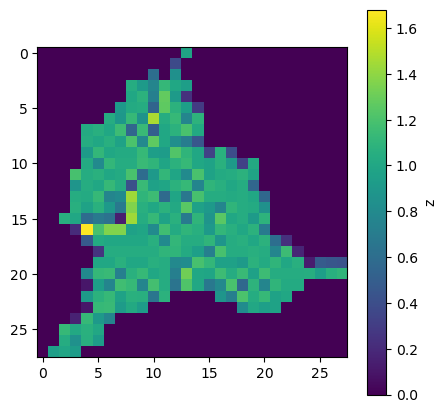

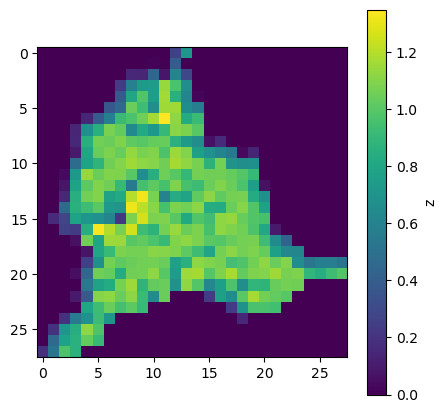

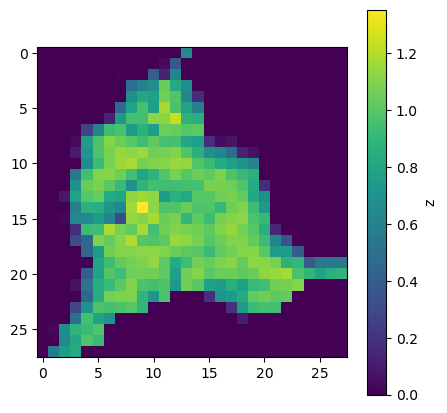

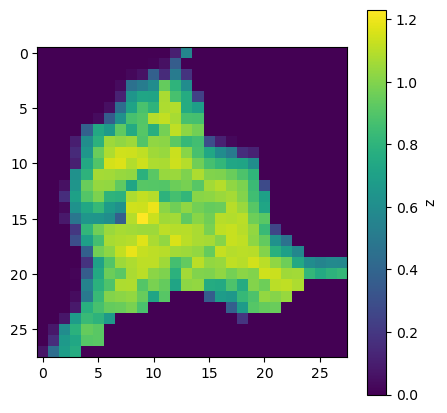

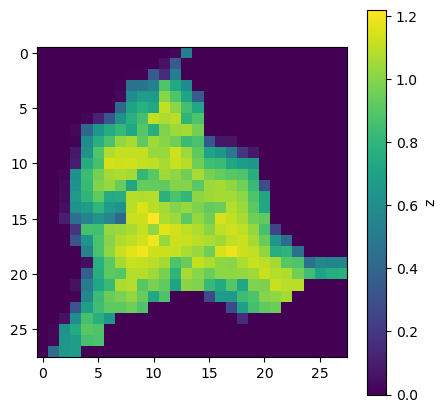

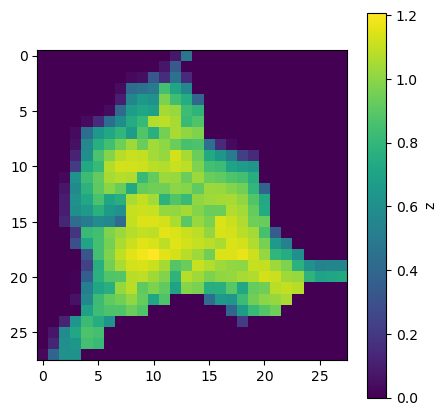

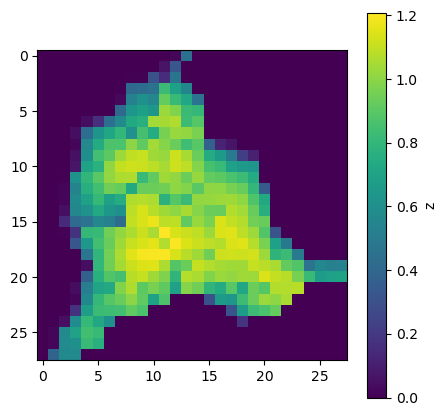

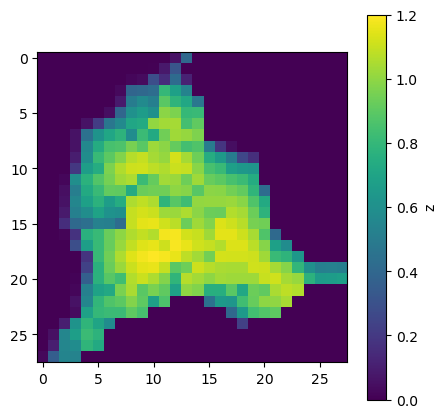

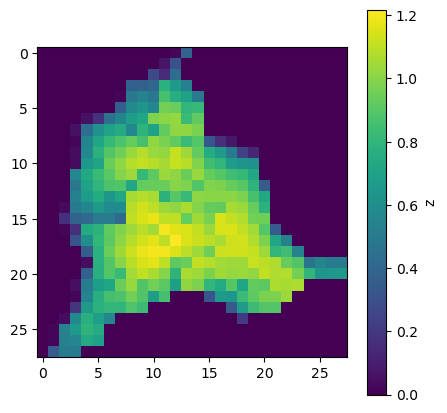

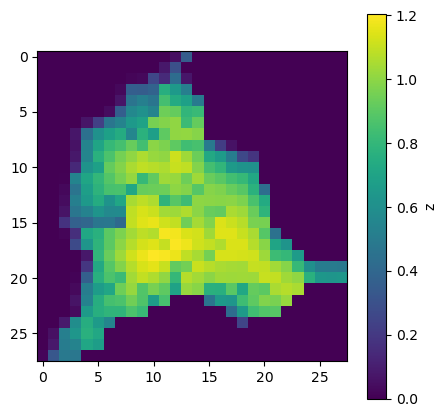

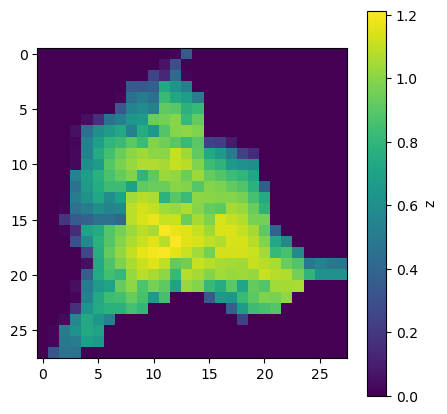

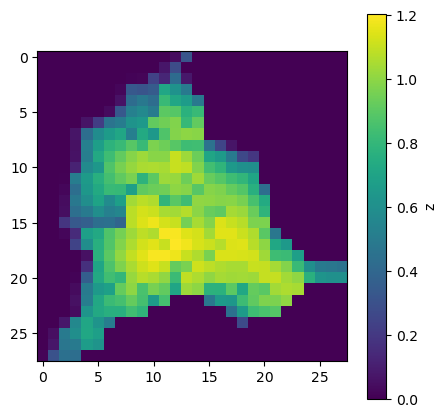

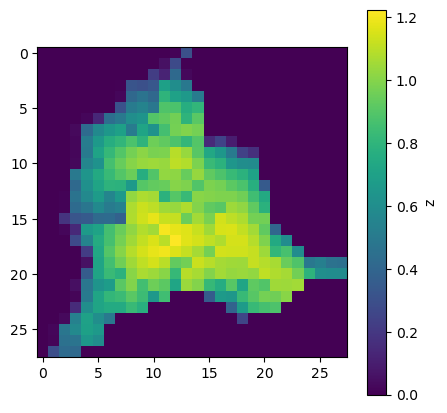

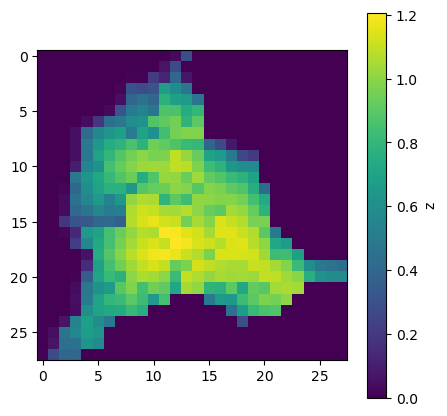

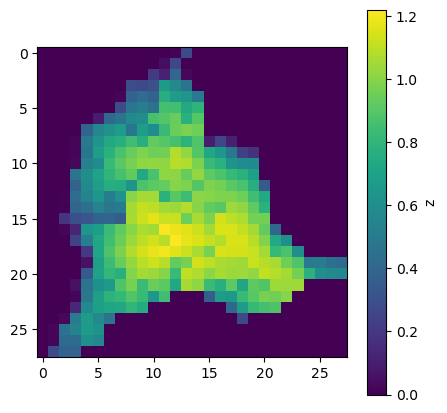

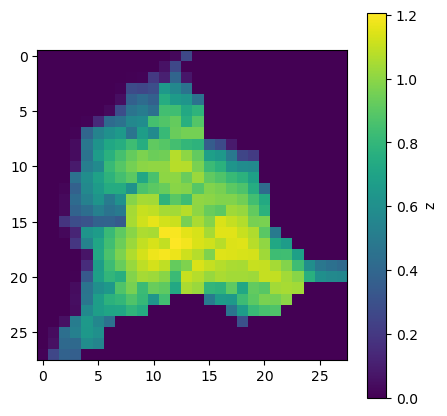

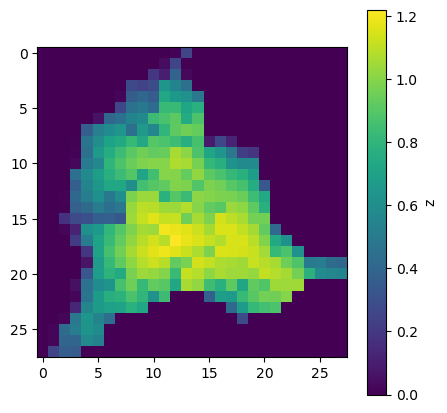

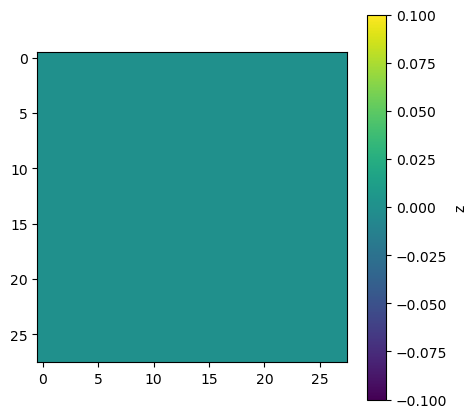

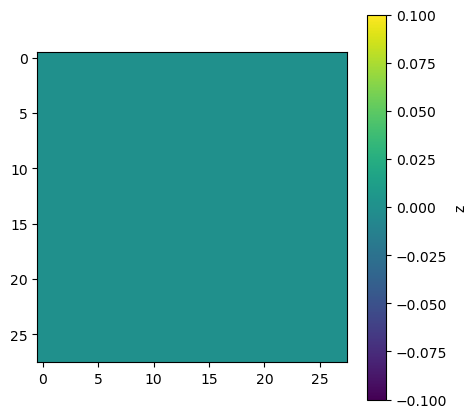

In [7]:
for i in range(0,20):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.imshow(hsw[:, :, i])
    plt.colorbar(label="z")
plt.show()

In [8]:
print(eta[:, :, 10])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  3.2432997  3.5955594  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         3.5836942  3.2177541
  3.3922064  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         3.5213199  3.497422   3.5469313  3.7388701  3.6629672
  3.423098   3.1135132  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         3.4466035  3.740726   3.7766407  3.7658026  3.610393

[20 27]


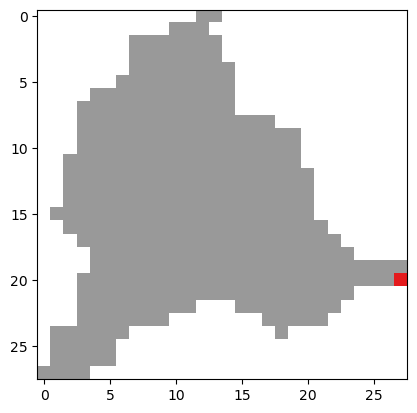

In [9]:
outlet_indices = model.mesh.outlet_indices
print(outlet_indices)
base = np.zeros(shape=(mesh["nrow"], mesh["ncol"]))
base = np.where(mesh["active_cell"] == 0, np.nan, base)
for pos in mesh["gauge_pos"]:
    base[outlet_indices[0], outlet_indices[1]] = 1

plt.imshow(base, cmap="Set1_r");
plt.show()

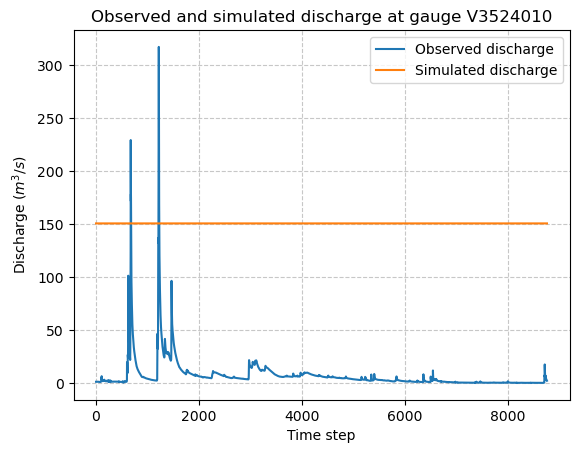

In [10]:
code = model.mesh.code[0]

plt.plot(model.response_data.q[0, :], label="Observed discharge");

plt.plot(model.response.q[0, :], label="Simulated discharge");

plt.xlabel("Time step");

plt.ylabel("Discharge ($m^3/s$)");

plt.grid(ls="--", alpha=.7);

plt.legend();

plt.title(f"Observed and simulated discharge at gauge {code}");

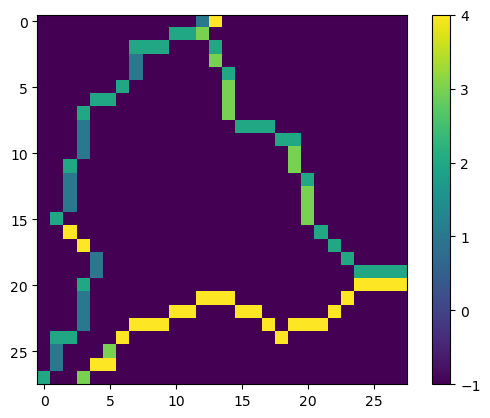

In [11]:
boundaries = model.mesh.boundaries
plt.imshow(boundaries)
plt.colorbar()
plt.show()